# Introduction

L'objectif de ce projet est de détecter les paneaux de signalisation présents dans une images.

# Dependencies

In [ ]:
import os
import cv2
import json
import time
import torch
import shutil
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Colab preparation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 12 20:16:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_path = os.path.join("drive", "MyDrive", "Projects", "TrafficSign")
project_files = os.listdir(project_path)
for f_name in project_files:
    file_exists = os.path.exists(f_name)
    if not file_exists and f_name != "outputs":
        f_path = os.path.join(project_path, f_name)
        shutil.copy(f_path, ".")
        print("COPIED : ", f_name)

In [ ]:
import zipfile

if not os.path.exists("./dataset"):
    with zipfile.ZipFile("TrafficSign.zip", 'r') as zip_ref:
        zip_ref.extractall()
else:
    print("DATASET ALREADY UNZIPPED!")

DATASET ALREADY UNZIPPED!


# Data preparation

In [ ]:
from datasets import (
    create_train_dataset,
    create_valid_dataset,
    create_train_loader,
    create_valid_loader
)
    
from custom_utils import (
    annot_lines_to_dict,
    get_train_transform,
    get_valid_transform,
    SaveBestModel,
    Averager,
    save_model,
    save_loss_plot
)

from config import (
    DATA_PATH, ANNT_PATH,
    NUM_WORKERS, RESIZE_TO, OUT_DIR, 
    CLASSES, NUM_CLASSES, NUM_EPOCHS,
    DEVICE, VISUALIZE_TRANSFORMED_IMAGES
)

In [ ]:
labels_path = os.path.join(DATA_PATH, "labels.txt")
with open(labels_path, "r") as f:
    lines = f.readlines()
    lines = [l.strip() for l in lines]
    f.close()

annotations = annot_lines_to_dict(lines)

# pass to numpy for better speed
annotations = np.array(annotations)

In [ ]:
not_representative = True
while not_representative:
    train_annots, test_annots = train_test_split(annotations, test_size=0.33, random_state=42)
    
    # get the present train labels
    train_labels = [annot["labels"] for annot in train_annots]
    train_labels = [label for labels_list in train_labels for label in labels_list]
    train_labels = np.unique(train_labels)
    if len(train_labels) == len(CLASSES):
        not_representative = False
        train_annots = train_annots.tolist()
        test_annots = test_annots.tolist()

In [ ]:
train_annot_filepath = os.path.join(ANNT_PATH, "train.json")
test_annot_filepath = os.path.join(ANNT_PATH, "test.json")

with open(train_annot_filepath, "w") as f:
    f.write(json.dumps(train_annots))
    f.close()
    
with open(test_annot_filepath, "w") as f:
    f.write(json.dumps(test_annots))
    f.close()

In [ ]:
train_dataset = create_train_dataset(train_annot_filepath, transforms = get_train_transform(), size = RESIZE_TO)
valid_dataset = create_valid_dataset(test_annot_filepath, transforms = get_valid_transform(), size = RESIZE_TO)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 496
Number of validation samples: 245



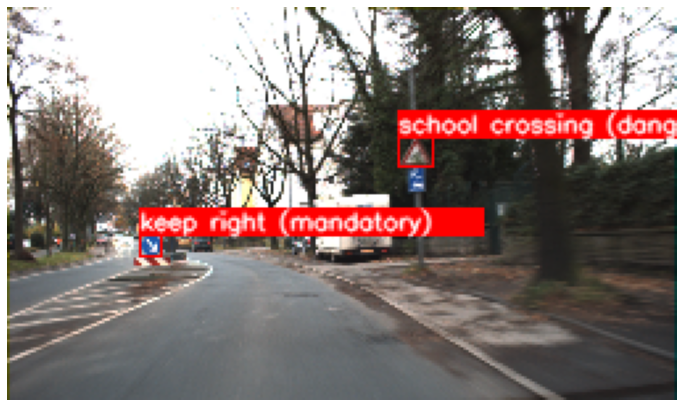

In [ ]:
if VISUALIZE_TRANSFORMED_IMAGES:
    from custom_utils import show_tranformed_image
    show_tranformed_image(train_loader)

# Create Model

In [ ]:
from model import create_model

In [ ]:
# initialize the model
model = create_model(num_classes = NUM_CLASSES)

# move to the computation device
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.005)

# Train Model

In [ ]:
from train import train, validate

Epoch :1 (0.433 min) train loss: 0.827 validation loss: 0.563 EarlyStop trigger 0

Best validation loss: 0.5625607669353485

Saving best model for epoch: 1

Epoch :2 (0.430 min) train loss: 0.560 validation loss: 0.576 EarlyStop trigger 0
Epoch :3 (0.426 min) train loss: 0.531 validation loss: 0.533 EarlyStop trigger 0

Best validation loss: 0.5334148481488228

Saving best model for epoch: 3

Epoch :4 (0.425 min) train loss: 0.480 validation loss: 0.454 EarlyStop trigger 0

Best validation loss: 0.4544964097440243

Saving best model for epoch: 4

Epoch :5 (0.432 min) train loss: 0.429 validation loss: 0.442 EarlyStop trigger 0

Best validation loss: 0.44186605885624886

Saving best model for epoch: 5

Epoch :6 (0.428 min) train loss: 0.404 validation loss: 0.425 EarlyStop trigger 0

Best validation loss: 0.42482202500104904

Saving best model for epoch: 6

Epoch :7 (0.429 min) train loss: 0.384 validation loss: 0.406 EarlyStop trigger 0

Best validation loss: 0.4061451107263565

Saving

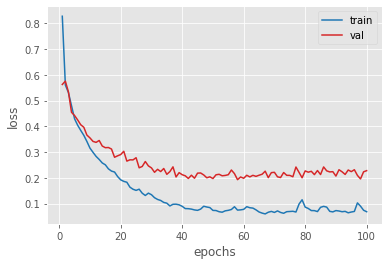

SAVING PLOTS COMPLETE...


In [ ]:
model = train(train_loader, valid_loader, model, optimizer)

# Visualize model results

In [ ]:
from custom_utils import show_inference_results, visualize
from config import IMGS_PATH, CLASSES

In [ ]:
def show_inference_results(image, model):
    """
    """
    inputs = [np.array(image).transpose(2, 0, 1) / 255.0]
    inputs = [torch.FloatTensor(im) for im in inputs]
    inputs = [im.to("cpu") for im in inputs]
    outputs = model(inputs)
    for output in outputs:
        boxes = output["boxes"].detach().to(torch.int).numpy()
        scores = output["scores"].detach().numpy()
        labels = output["labels"].detach().numpy()
        
        # filter boxes, scores, and labels to keep 
        # only predictions with above 70% certenty
        threshold = 0.4
        boxes = [boxes[i] for i in range(len(scores)) if scores[i] > threshold]
        labels = [labels[i] for i in range(len(scores)) if scores[i] > threshold]
        visualize(image, boxes, labels, CLASSES)

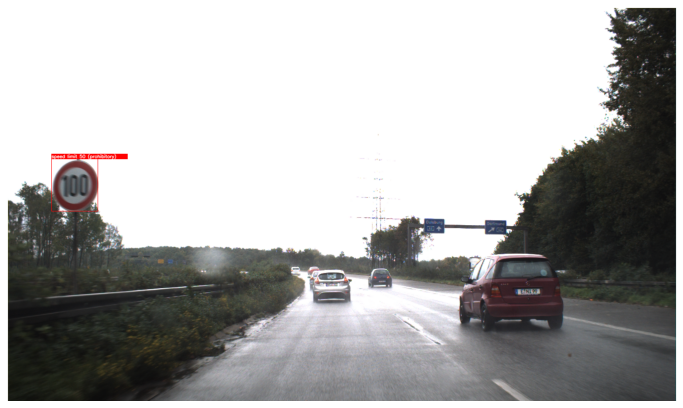

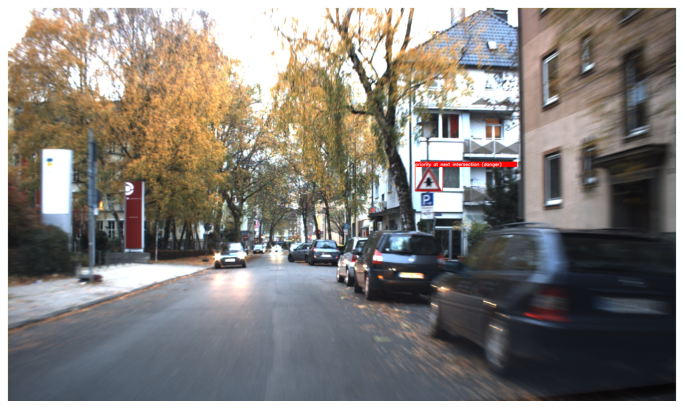

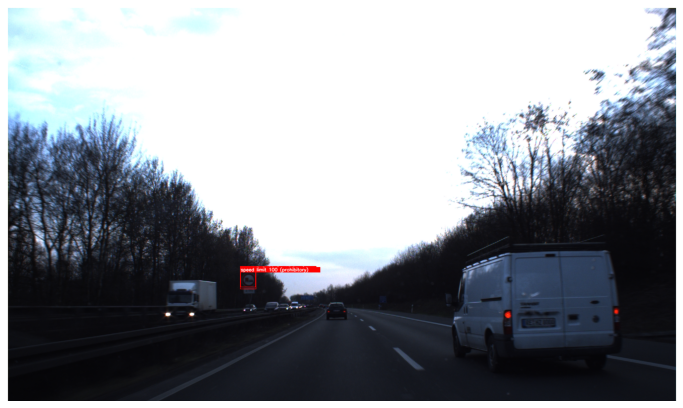

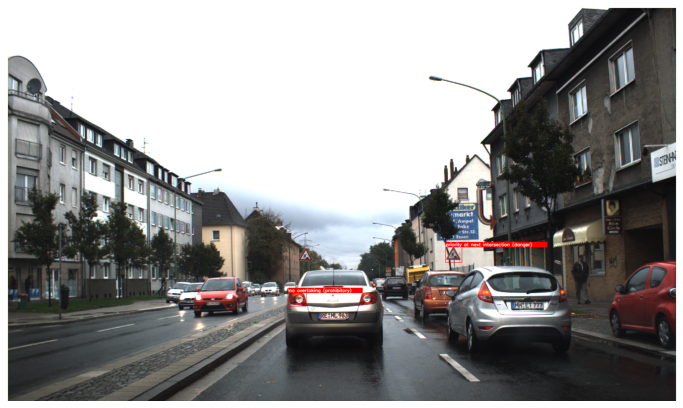

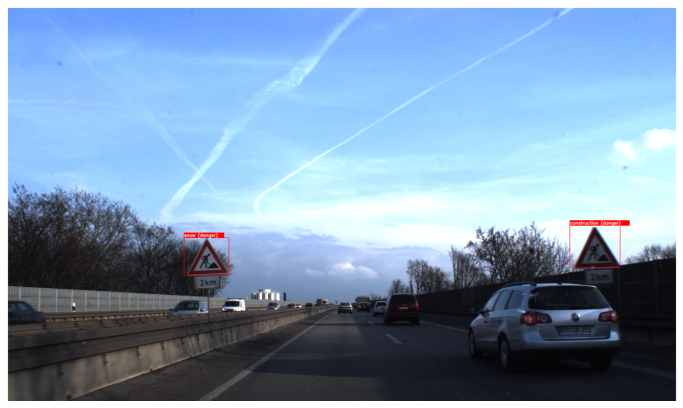

In [ ]:
with open(test_annot_filepath, "r") as f:
    test_annots = json.loads(f.read())
    f.close()

for i in range(5):
    annot = test_annots[i]
    file_name = annot["file_name"]
    image_path = os.path.join(IMGS_PATH, file_name)
    image = plt.imread(image_path)
    model.to("cpu")
    model.eval()
    show_inference_results(image, model)